<a href="https://colab.research.google.com/github/Nov05/DS-Unit-2-Linear-Models/blob/master/module3-understanding-linear-regression/understanding_linear_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# modified by nov05 on 2019-07-10
# module3-understanding-linear-regression/

In [0]:
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error, \
     mean_squared_error, r2_score

import itertools
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot

In [0]:
# https://stackoverflow.com/a/47230966
# Plotly notebook mode with google colaboratory
# You need to define this function
# And call it in each offline plotting cell

def configure_plotly_browser_state():
    import IPython
    display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext',
            },
          });
        </script>
        '''))
init_notebook_mode(connected=True)

_Lambda School Data Science — Linear Models_

# Understanding Linear Regression

#### Objectives
- understand how ordinary least squares regression minimizes the sum of squared errors
- understand how linear algebra can solve ordinary least squares regression
- get and interpret coefficients of a linear model
- visualize a line of best fit in 2D, and hyperplane in 3D
- use regression metrics: MSE, RMSE, MAE, R^2

#### Extra Links
- [Statistics 101: Simple Linear Regression](https://www.youtube.com/watch?v=ZkjP5RJLQF4) (20 minute video)
- [_An Introduction to Statistical Learning_](http://www-bcf.usc.edu/~gareth/ISL/ISLR%20Seventh%20Printing.pdf), Chapter 3.1, Simple Linear Regression, & 3.2, Multiple Linear Regression
- Priceonomics, [The Discovery of Statistical Regression](https://priceonomics.com/the-discovery-of-statistical-regression/)
- Priceonomics, [Why the Father of Modern Statistics Didn’t Believe Smoking Caused Cancer](https://priceonomics.com/why-the-father-of-modern-statistics-didnt-believe/)
- Harvard Business Review, [When to Act on a Correlation, and When Not To](https://hbr.org/2014/03/when-to-act-on-a-correlation-and-when-not-to)
- [xkcd 552: Correlation](https://www.explainxkcd.com/wiki/index.php/552:_Correlation)
- [xkcd 1725: Linear Regression](https://www.explainxkcd.com/wiki/index.php/1725:_Linear_Regression)

## What is Linear Regression?

[Linear Regression](https://en.wikipedia.org/wiki/Linear_regression) is a statistical model that seeks to describe the relationship between some y variable and one or more x variables. 

In the simplest case, linear regression seeks to fit a straight line through a cloud of points. This line is referred to as the "regression line" or "line of best fit." This line tries to summarize the relationship between our X and Y in a way that enables us to use the equation for that line to make predictions.

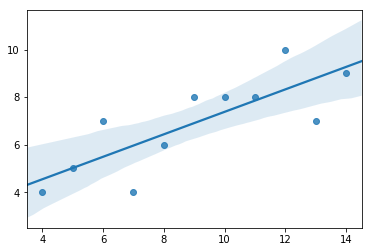

In [0]:
%matplotlib inline
import seaborn as sns
x = [10,  8, 13,  9, 11, 14,  6,  4, 12,  7,  5]
y = [ 8,  6,  7,  8,  8,  9,  7,  4, 10,  4,  5]
sns.regplot(x, y);



### Synonyms for "y variable" 
- Dependent Variable
- Response Variable
- Outcome Variable 
- Predicted Variable
- Measured Variable
- Explained Variable
- Label
- Target

### Synonyms for "x variable"
- Independent Variable
- Explanatory Variable
- Regressor
- Covariate
- Feature

## Simple Linear Regresion

#### Making Predictions

Say that we were trying to create a model that captured the relationship between temperature outside and ice cream sales. In Machine Learning our goal is often different that of other flavors of Linear Regression Analysis, because we're trying to fit a model to this data with the intention of making **predictions** on new data (in the future) that we don't have yet.

#### What are we trying to predict?

So if we had measured ice cream sales and the temprature outside on 11 different days, at the end of our modeling **what would be the thing that we would want to predict? - Ice Cream Sales or Temperature?**

We would probably want to be measuring temperature with the intention of using that to **forecast** ice cream sales. If we were able to successfully forecast ice cream sales from temperature, this might help us know beforehand how much ice cream to make or how many cones to buy or on which days to open our store, etc. Being able to make predictions accurately has a lot of business implications. This is why making accurate predictions is so valuable (And in large part is why data scientists are paid so well).

#### y variable intuition

We want the thing that we're trying to predict to serve as our **y** variable. This is why it's sometimes called the "predicted variable." We call it the "dependent" variable because our prediction for how much ice cream we're going to sell "depends" on the temperature outside. 

#### x variable intuition

All other variables that we use to predict our y variable (we're going to start off just using one) we call our **x** variables. These are called our "independent" variables because they don't *depend* on y, they "explain" y. Hence they are also referred to as our "explanatory" variables.

## Example: Predict presidential election voting

#### Douglas Hibbs, [Background Information on the ‘Bread and Peace’ Model of Voting in Postwar US Presidential Elections](https://douglas-hibbs.com/background-information-on-bread-and-peace-voting-in-us-presidential-elections/)

> Aggregate two-party vote shares going to candidates of the party holding the presidency during the postwar era are well explained by just two fundamental determinants:

> (1) Positively by weighted-average growth of per capita real disposable personal income over the term.  
> (2) Negatively by cumulative US military fatalities (scaled to population) owing to unprovoked, hostile deployments of American armed forces in foreign wars.

#### Data sources
- 1952-2012: Douglas Hibbs, [2014 lecture at Deakin University Melbourne](http://www.douglas-hibbs.com/HibbsArticles/HIBBS-PRESVOTE-SLIDES-MELBOURNE-Part1-2014-02-26.pdf), Slide 40
- 2016, Vote Share: [The American Presidency Project](https://www.presidency.ucsb.edu/statistics/elections)
- 2016, Recent Growth in Personal Incomes: [The 2016 election economy: the "Bread and Peace" model final forecast](https://angrybearblog.com/2016/11/the-2016-election-economy-the-bread-and-peace-model-final-forecast.html)
- 2016, US Military Fatalities: Assumption that Afghanistan War fatalities in 2012-16 occured at the same rate as 2008-12

In [0]:
import pandas as pd

columns = ['Year','Incumbent Party Candidate','Other Candidate','Incumbent Party Vote Share']

data = [[1952,"Stevenson","Eisenhower",44.6],
        [1956,"Eisenhower","Stevenson",57.76],
        [1960,"Nixon","Kennedy",49.91],
        [1964,"Johnson","Goldwater",61.34],
        [1968,"Humphrey","Nixon",49.60],
        [1972,"Nixon","McGovern",61.79],
        [1976,"Ford","Carter",48.95],
        [1980,"Carter","Reagan",44.70],
        [1984,"Reagan","Mondale",59.17],
        [1988,"Bush, Sr.","Dukakis",53.94],
        [1992,"Bush, Sr.","Clinton",46.55],
        [1996,"Clinton","Dole",54.74],
        [2000,"Gore","Bush, Jr.",50.27],
        [2004,"Bush, Jr.","Kerry",51.24],
        [2008,"McCain","Obama",46.32],
        [2012,"Obama","Romney",52.00], 
        [2016,"Clinton","Trump",48.2]]
        
votes = pd.DataFrame(data=data, columns=columns)

In [0]:
columns = ['Year','Average Recent Growth in Personal Incomes']

data = [[1952,2.40],
        [1956,2.89],
        [1960, .85],
        [1964,4.21],
        [1968,3.02],
        [1972,3.62],
        [1976,1.08],
        [1980,-.39],
        [1984,3.86],
        [1988,2.27],
        [1992, .38],
        [1996,1.04],
        [2000,2.36],
        [2004,1.72],
        [2008, .10],
        [2012, .95], 
        [2016, .10]]
        
growth = pd.DataFrame(data=data, columns=columns)

In [0]:
"""
Fatalities denotes the cumulative number of American military
fatalities per millions of US population the in Korea, Vietnam,
Iraq and Afghanistan wars during the presidential terms
preceding the 1952, 1964, 1968, 1976 and 2004, 2008 and
2012 elections.

http://www.douglas-hibbs.com/HibbsArticles/HIBBS-PRESVOTE-SLIDES-MELBOURNE-Part1-2014-02-26.pdf
"""

columns = ['Year','US Military Fatalities per Million']

data = [[1952,190],
        [1956,  0],
        [1960,  0],
        [1964,  1],
        [1968,146],
        [1972,  0],
        [1976,  2],
        [1980,  0],
        [1984,  0],
        [1988,  0],
        [1992,  0],
        [1996,  0],
        [2000,  0],
        [2004,  4],
        [2008, 14],
        [2012,  5], 
        [2016,  5]]
        
deaths = pd.DataFrame(data=data, columns=columns)

In [0]:
df = votes.merge(growth).merge(deaths)

### Plot univariate correlations
[Seaborn tutorial: Visualizing linear relationships](https://seaborn.pydata.org/tutorial/regression.html)

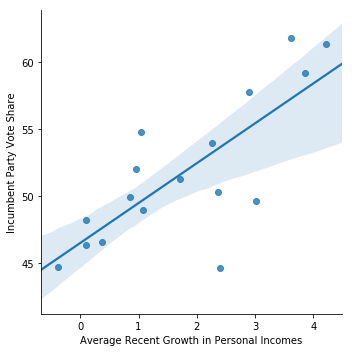

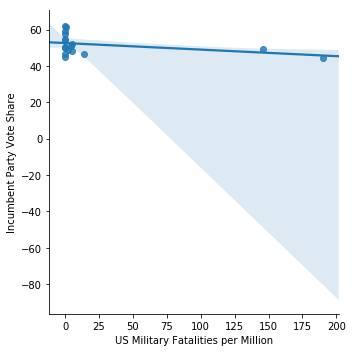

In [0]:
%matplotlib inline
import seaborn as sns

target = 'Incumbent Party Vote Share'
features = ['Average Recent Growth in Personal Incomes', 
            'US Military Fatalities per Million']

for feature in features:
    sns.lmplot(x=feature, y=target, data=df)

We can see from the scatterplot that these data points seem to follow a somewhat linear relationship for the "Average Recent Growth in Personal Incomes" feature. This means that we could probably summarize their relationship well by fitting a line of best fit to these points. Lets do it.


## The Equation for a Line

A common equation for a line is:

\begin{align}
y = mx + b
\end{align}

Where $m$ is the slope of our line and $b$ is the y-intercept. 

If we want to plot a line through our cloud of points we figure out what these two values should be. Linear Regression seeks to **estimate** the slope and intercept values that describe a line that best fits the data points.

## The Anatomy of Linear Regression

- Intercept: The $b$ value in our line equation $y=mx+b$
- Slope: The $m$ value in our line equation $y=mx+b$. These two values together define our regression line.
- $\hat{y}$ : A prediction
- Line of Best Fit (Regression Line)
- Predicted (fitted) Values: Points on our regression line
- Observed Values: Points from our dataset
- Error: The distance between predicted and observed values.


Ordinary Least Squares Regression is a way to solve for $m$ and $b$.

Let's start by seeing what would happen if we just guessed and checked some values for $m$ and $b$. 

What's the line of "best" fit look like? What's the error?


In [0]:
# TODO

## R Squared:  $R^2$

One final attribute of linear regressions that we're going to talk about today is a measure of goodness of fit known as $R^2$ or R-squared. $R^2$ is a statistical measure of how close the data are fitted to our regression line. A helpful interpretation for the $R^2$ is the percentage of the dependent variable that is explained by the model.

In other words, the $R^2$ is the percentage of y that is explained by the x variables included in the model. For this reason the $R^2$ is also known as the "coefficient of determination," because it explains how much of y is explained (or determined) by our x varaibles. We won't go into the calculation of $R^2$ today, just know that a higher $R^2$ percentage is nearly always better and indicates a model that fits the data more closely. 

## Residual Error 

The residual error is the distance between points in our dataset and our regression line.

Mean Absolute Error: 2.556470588235295
R^2: 0.5799637280695265


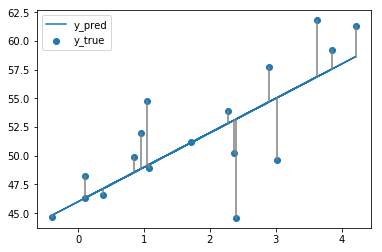

In [0]:
def regression_residuals(df, feature, target, m, b):
    x = df[feature]
    y = df[target]
    y_pred = m*x + b
    
    plt.scatter(x, y, label='y_true')
    plt.plot(x, y_pred, label='y_pred')
    plt.legend()
    
    # Plot residual errors
    for x, y1, y2 in zip(x, y, y_pred):
        plt.plot((x, x), (y1, y2), color='grey')
        
    mae = mean_absolute_error(y, y_pred) 
    r2 = r2_score(y, y_pred)
    print('Mean Absolute Error:', mae)
    print('R^2:', r2)
        
regression_residuals(df, feature='Average Recent Growth in Personal Incomes', 
                     target='Incumbent Party Vote Share', m=3, b=46)

In [0]:
from ipywidgets import interact, fixed

interact(regression_residuals, 
         df=fixed(df), 
         feature=fixed('Average Recent Growth in Personal Incomes'), 
         target=fixed('Incumbent Party Vote Share'), 
         m=(-10,10,0.5), 
         b=(40,60,0.5));

interactive(children=(FloatSlider(value=0.0, description='m', max=10.0, min=-10.0, step=0.5), FloatSlider(valu…

## More Formal Notation

<img src="https://cdn-images-1.medium.com/max/1436/1*_TqRJ9SmwFzRigJhMiN2uw.png" width="600">

We have talked about a line of regression being represented like a regular line $y=mx+b$ but as we get to more complicated versions we're going to need to extend this equation. So lets establish the proper terminology.

**X** - Independent Variable, predictor variable, explanatory variable, regressor, covariate

**Y** - Response variable, predicted variable, measured vairable, explained variable, outcome variable

$\beta_0$ - "Beta Naught" or "Beta Zero", the intercept value. This is how much of y would exist if X were zero. This is sometimes represented by the letter "a" but I hate that. So it's "Beta 0" during my lecture.

$\beta_1$ - "Beta One" The primary coefficient of interest. This values is the slope of the line that is estimated by "minimizing the sum of the squared errors/residuals" - We'll get to that. 

$\epsilon$ - "Epsilon" The "error term", random noise, things outside of our model that affect y.

## Minimizing the Sum of the Squared Error

The most common method of estimating our $\beta$ parameters  is what's known as "Ordinary Least Squares" (OLS). (There are different methods of arriving at a line of best fit). OLS estimates the parameters that minimize the squared distance between each point in our dataset and our line of best fit. 

\begin{align}
SSE = \sum(y_i - \hat{y})^2
\end{align}


Mean Squared Error: 12.00542352941177
Root Mean Squared Error: 3.4648843457483207
Mean Absolute Error: 2.556470588235295
R^2: 0.5799637280695265


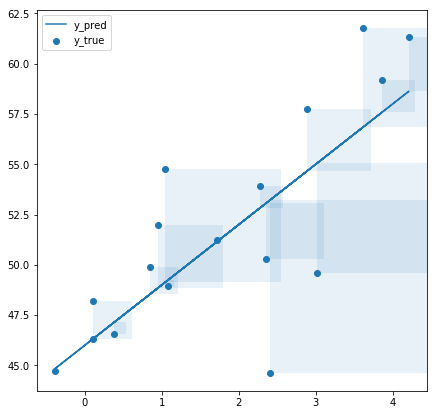

In [0]:
from matplotlib.patches import Rectangle
import numpy as np
from sklearn.metrics import mean_squared_error

def regression_squared_errors(df, feature, target, m, b):
    x = df[feature]
    y = df[target]
    y_pred = m*x + b
    
    fig = plt.figure(figsize=(7,7))
    ax = plt.axes()
    ax.scatter(x, y, label='y_true')
    ax.plot(x, y_pred, label='y_pred')
    ax.legend()
    
    # Plot square errors
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    scale = (xmax-xmin)/(ymax-ymin)
    for x, y1, y2 in zip(x, y, y_pred):
        bottom_left = (x, min(y1, y2))
        height = abs(y1 - y2)
        width = height * scale
        ax.add_patch(Rectangle(xy=bottom_left, width=width, height=height, alpha=0.1))
        
    mse = mean_squared_error(y, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    print('Mean Squared Error:', mse)
    print('Root Mean Squared Error:', rmse)
    print('Mean Absolute Error:', mae)
    print('R^2:', r2)
    
regression_squared_errors(df, feature='Average Recent Growth in Personal Incomes', 
           target='Incumbent Party Vote Share', m=3, b=46)

In [0]:
interact(regression_squared_errors, 
         df=fixed(df), 
         feature=fixed('Average Recent Growth in Personal Incomes'), 
         target=fixed('Incumbent Party Vote Share'), 
         m=(-10,10,0.5), 
         b=(40,60,0.5));

interactive(children=(FloatSlider(value=0.0, description='m', max=10.0, min=-10.0, step=0.5), FloatSlider(valu…

## Hypotheses

In [0]:
b = 46
ms = np.arange(-10,10,0.5)
sses = []
feature = 'Average Recent Growth in Personal Incomes'

for m in ms:
    predictions = m * df[feature] + b
    errors = predictions - df[target]
    square_errors = errors ** 2
    sse = square_errors.sum()
    sses.append(sse)
    
hypotheses = pd.DataFrame({'Slope': ms})
hypotheses['Intercept'] = b
hypotheses['Sum of Square Errors'] = sses

hypotheses

,Slope,Intercept,Sum of Square Errors
0,-10.0,46,15215.58740
1,-9.5,46,14095.52845
2,-9.0,46,13018.88500
3,-8.5,46,11985.65705
4,-8.0,46,10995.84460
5,-7.5,46,10049.44765
6,-7.0,46,9146.46620
7,-6.5,46,8286.90025
8,-6.0,46,7470.74980
9,-5.5,46,6698.01485


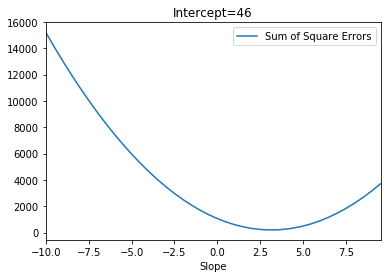

In [0]:
hypotheses.plot(x='Slope', y='Sum of Square Errors', 
                title=f'Intercept={b}');

### 3D plot

In [0]:
xvalues = np.array([0, 1, 2, 3, 4])
yvalues = np.array([0, 1, 2, 3])
xx, yy = np.meshgrid(xvalues, yvalues)
print(xx)
print(yy)
print(xx.shape)

[[0 1 2 3 4]
 [0 1 2 3 4]
 [0 1 2 3 4]
 [0 1 2 3 4]]
[[0 0 0 0 0]
 [1 1 1 1 1]
 [2 2 2 2 2]
 [3 3 3 3 3]]
(4, 5)


In [0]:
feature = 'Average Recent Growth in Personal Incomes'
ms = np.arange(-10, 10, 0.5) # slope
bs = np.arange(46-10, 46+10, 0.5) # intercept
rownum, colnum = len(bs), len(ms)
sses = np.zeros((rownum, colnum))

ms, bs = np.meshgrid(ms, bs)

for i in range(rownum):
  if bs[i,0]==46: save_i=i
  for j in range(colnum):
    predictions = ms[i,j] * df[feature] + bs[i,j]
    errors = predictions - df[target]
    square_errors = errors ** 2
    sses[i,j] = square_errors.sum()

print(sses.shape)
print(sses[0])
print(bs[save_i,:2])

(40, 40)
[24989.1874  23564.52845 22183.285   20845.45705 19551.0446  18300.04765
 17092.4662  15928.30025 14807.5498  13730.21485 12696.2954  11705.79145
 10758.703    9855.03005  8994.7726   8177.93065  7404.5042   6674.49325
  5987.8978   5344.71785  4744.9534   4188.60445  3675.671    3206.15305
  2780.0506   2397.36365  2058.0922   1762.23625  1509.7958   1300.77085
  1135.1614   1012.96745   934.189     898.82605   906.8786    958.34665
  1053.2302   1191.52925  1373.2438   1598.37385]
[46. 46.]


In [0]:
configure_plotly_browser_state()
data = [go.Surface(x=bs,
                   y=ms,
                   z=sses,
                   name='',
                   opacity=0.6,
                   colorbar=dict(x=0.8, len=0.5, thickness=10,
                                 outlinecolor='white', 
                                 outlinewidth=0)
                  ),
        go.Scatter3d(x=bs[save_i],
                     y=ms[save_i],
                     z=sses[save_i],
                     name='',
                     mode='markers+lines',
                     marker=dict(size=0.1,
                                 color="black", 
                                 opacity=0.4,
                                 line=dict(width=0.01, color='black'),),
                     projection=dict(x=dict(show=True, opacity=0.15, scale=10),
                                     y=dict(show=True, opacity=0.15, scale=10),
                                     z=dict(show=True, opacity=0.15, scale=10),),
                    )
       ]
layout = go.Layout(autosize=False,
                   width=600, height=400,
                   margin=dict(l=5, r=0, b=5, t=10),
                   scene={'xaxis': {'title': 'x = Intercept'}, 
                          'yaxis': {'title': 'y = Slope'}, 
                          'zaxis': {'title': 'z = Sum of Square Errors'}}, 
                   title=go.layout.Title(text="feature = 'Average Recent Growth in Personal Incomes'", 
                                         xref='paper', x=0.1, y=0.92, font={'size':12})
                  )
fig = go.Figure(data=data, layout=layout)
iplot(fig)

## Scikit-learn

#### Jake VanderPlas, [Python Data Science Handbook, Chapter 5.2, Introducing Scikit-Learn](https://jakevdp.github.io/PythonDataScienceHandbook/05.02-introducing-scikit-learn.html), Scikit-Learn's Estimator API

> Most commonly, the steps in using the Scikit-Learn estimator API are as follows (we will step through a handful of detailed examples in the sections that follow).

> 1. Choose a class of model by importing the appropriate estimator class from Scikit-Learn. 
> 2. Choose model hyperparameters by instantiating this class with desired values. 
> 3. Arrange data into a features matrix and target vector following the discussion above.
> 4. Fit the model to your data by calling the `fit()` method of the model instance.
> 5. Apply the Model to new data: For supervised learning, often we predict labels for unknown data using the `predict()` method.

In [0]:
df.columns

Index(['Year', 'Incumbent Party Candidate', 'Other Candidate',
       'Incumbent Party Vote Share',
       'Average Recent Growth in Personal Incomes',
       'US Military Fatalities per Million'],
      dtype='object')

In [0]:
# TODO


## Linear Algebra!

The same result that is found by minimizing the sum of the squared errors can be also found through a linear algebra process known as the "Least Squares Solution:"

\begin{align}
\hat{\beta} = (X^{T}X)^{-1}X^{T}y
\end{align}

Before we can work with this equation in its linear algebra form we have to understand how to set up the matrices that are involved in this equation. 

### The $\beta$ vector

The $\beta$ vector represents all the parameters that we are trying to estimate, our $y$ vector and $X$ matrix values are full of data from our dataset. The $\beta$ vector holds the variables that we are solving for: $\beta_0$ and $\beta_1$

Now that we have all of the necessary parts we can set them up in the following equation:

\begin{align}
y = X \beta + \epsilon
\end{align}

Since our $\epsilon$ value represents **random** error we can assume that it will equal zero on average.

\begin{align}
y = X \beta
\end{align}

The objective now is to isolate the $\beta$ matrix. We can do this by pre-multiplying both sides by "X transpose" $X^{T}$.

\begin{align}
X^{T}y =  X^{T}X \beta
\end{align}

Since anything times its transpose will result in a square matrix, if that matrix is then an invertible matrix, then we should be able to multiply both sides by its inverse to remove it from the right hand side. (We'll talk tomorrow about situations that could lead to $X^{T}X$ not being invertible.)

\begin{align}
(X^{T}X)^{-1}X^{T}y =  (X^{T}X)^{-1}X^{T}X \beta
\end{align}

Since any matrix multiplied by its inverse results in the identity matrix, and anything multiplied by the identity matrix is itself, we are left with only $\beta$ on the right hand side:

\begin{align}
(X^{T}X)^{-1}X^{T}y = \hat{\beta}
\end{align}

We will now call it "beta hat" $\hat{\beta}$ because it now represents our estimated values for $\beta_0$ and $\beta_1$

### Lets calculate our $\beta$ coefficients with numpy!

https://www.programcreek.com/python/example/88631/statsmodels.api.add_constant  

In [0]:
feature, target

('Average Recent Growth in Personal Incomes', 'Incumbent Party Vote Share')

In [0]:
from statsmodels.api import add_constant

X = add_constant(df[feature].values)
print('X')
print(X)

y = df[target].values[:, np.newaxis]
print('y')
print(y)

X_transpose = X.T
print('X Transpose')
print(X_transpose)

X_transpose_X = X_transpose @ X
print('X Transpose X')
print(X_transpose_X)

X_transpose_X_inverse = np.linalg.inv(X_transpose_X)
print('X Transpose X Inverse')
print(X_transpose_X_inverse)

X_transpose_y = X_transpose @ y
print('X Transpose y')
print(X_transpose_y)

beta_hat = X_transpose_X_inverse @ X_transpose_y
print('Beta Hat')
print(beta_hat)

X
[[ 1.    2.4 ]
 [ 1.    2.89]
 [ 1.    0.85]
 [ 1.    4.21]
 [ 1.    3.02]
 [ 1.    3.62]
 [ 1.    1.08]
 [ 1.   -0.39]
 [ 1.    3.86]
 [ 1.    2.27]
 [ 1.    0.38]
 [ 1.    1.04]
 [ 1.    2.36]
 [ 1.    1.72]
 [ 1.    0.1 ]
 [ 1.    0.95]
 [ 1.    0.1 ]]
y
[[44.6 ]
 [57.76]
 [49.91]
 [61.34]
 [49.6 ]
 [61.79]
 [48.95]
 [44.7 ]
 [59.17]
 [53.94]
 [46.55]
 [54.74]
 [50.27]
 [51.24]
 [46.32]
 [52.  ]
 [48.2 ]]
X Transpose
[[ 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
   1.    1.    1.    1.    1.  ]
 [ 2.4   2.89  0.85  4.21  3.02  3.62  1.08 -0.39  3.86  2.27  0.38  1.04
   2.36  1.72  0.1   0.95  0.1 ]]
X Transpose X
[[17.    30.46 ]
 [30.46  86.831]]
X Transpose X Inverse
[[ 0.15835959 -0.05555197]
 [-0.05555197  0.03100405]]
X Transpose y
[[ 881.08  ]
 [1674.6167]]
Beta Hat
[[46.49920976]
 [ 2.97417709]]


# Multiple Regression

Simple or bivariate linear regression involves a single $x$ variable and a single $y$ variable. However, we can have many $x$ variables. A linear regression model that involves multiple x variables is known as **Multiple** Regression (NOT MULTIVARIATE).

\begin{align}
y = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + ... + \beta_n X_n + \epsilon
\end{align}

In [0]:
df.columns

Index(['Year', 'Incumbent Party Candidate', 'Other Candidate',
       'Incumbent Party Vote Share',
       'Average Recent Growth in Personal Incomes',
       'US Military Fatalities per Million'],
      dtype='object')

In [0]:
# TODO
features = ['Average Recent Growth in Personal Incomes', 
            'US Military Fatalities per Million']

X = add_constant(df[features].values)
print('X', X.shape, '\n', X[:2], '\n')

y = df[target].values[:, np.newaxis]
print('y', y.shape, '\n', y[:2], '\n')

X_t = X.T
print('X Transpose', X_t.shape, '\n', X_t[:2], '\n')

X_t_X = X_t @ X
print('X Transpose X', X_t_X.shape, '\n', X_t_X[:2], '\n')

X_t_X_i = np.linalg.inv(X_t_X)
print('X Transpose X Inverse', X_t_X_i.shape, '\n', X_t_X_i[:2], '\n')

X_t_y = X_t @ y
print('X Transpose y', X_t_y.shape, '\n', X_t_y[:2], '\n')

beta_hat = X_t_X_i @ X_t_y
print('Beta Hat', '\n', beta_hat)

X (17, 3) 
 [[  1.     2.4  190.  ]
 [  1.     2.89   0.  ]] 

y (17, 1) 
 [[44.6 ]
 [57.76]] 

X Transpose (3, 17) 
 [[ 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
   1.    1.    1.    1.    1.  ]
 [ 2.4   2.89  0.85  4.21  3.02  3.62  1.08 -0.39  3.86  2.27  0.38  1.04
   2.36  1.72  0.1   0.95  0.1 ]] 

X Transpose X (3, 3) 
 [[ 17.     30.46  367.   ]
 [ 30.46   86.831 916.82 ]] 

X Transpose X Inverse (3, 3) 
 [[ 1.59442936e-01 -5.43403754e-02 -1.50741374e-04]
 [-5.43403754e-02  3.23590714e-02 -1.68585651e-04]] 

X Transpose y (3, 1) 
 [[ 881.08  ]
 [1674.6167]] 

Beta Hat 
 [[46.88551694]
 [ 3.40621407]
 [-0.05375223]]


## Visualize hyperplane of best fit in 3D

In [0]:
# TODO
features = ['Average Recent Growth in Personal Incomes', 
            'US Military Fatalities per Million']
X = df[features]
y = df[target].values[:, np.newaxis]

model_lr = linear_model.LinearRegression()
model_lr.fit(X, y)
y_pred = model_lr.predict(X)

print('Coefficients:', model_lr.coef_)
print('Intercept:', model_lr.intercept_)
print("Mean absolute error: %.2f"
      % mean_absolute_error(y, y_pred))
print("Mean squared error: %.2f"
      % mean_squared_error(y, y_pred))
# Explained variance score: 1 is perfect prediction
print('R2 variance score: %.2f' % r2_score(y, y_pred))

Coefficients: [[ 3.40621407 -0.05375223]]
Intercept: [46.88551694]
Mean absolute error: 1.40
Mean squared error: 3.70
R2 variance score: 0.87


In [0]:
def viz3D(fitted_model, X, features, y, target='', num=100):
    """
    Visualize model predictions in 3D, for regression model fit on 2 features
    
    Parameters
    ----------
    fitted_model : scikit-learn model, already fitted
    X : pandas dataframe, which was used to fit model
    features : list of strings, column names of the 2 features
    target : string, name of target
    num : int, number of grid points for each feature
    
    References
    ----------
    https://plot.ly/python/3d-charts/
    """
    feature1, feature2 = features
    min1, max1 = X[feature1].min(), X[feature1].max()
    min2, max2 = X[feature2].min(), X[feature2].max()
    x1 = np.linspace(min1, max1, num)
    x2 = np.linspace(min2, max2, num)
    combos = list(itertools.product(x1, x2))
    Z = fitted_model.predict(combos).reshape(num, num)
    
    configure_plotly_browser_state()
    trace1 = go.Scatter3d(x=X[feature1], y=X[feature2], z=y,
                          name='',
                          mode='markers',
                          marker=dict(size=5,
                                      color="black", 
                                      opacity=0.4,
                                      line=dict(width=0.01, color='black'),
                                     ),
                         )
    data = [go.Surface(x=x1, y=x2, z=Z,
                       name='',
                       opacity=0.4,
                       colorbar=dict(len=0.5, thickness=10,
                                     outlinecolor='white', 
                                     outlinewidth=0)
                      ), 
            trace1]
    layout = go.Layout(
        autosize=False,
        width=500,
        height=300,
        margin=dict(l=0, r=0, b=0, t=0),
        scene={'xaxis': {'title': feature1, 'range': [min1,max1], 'showticklabels': True}, 
               'yaxis': {'title': feature2, 'range': [min2,max2], 'showticklabels': True}, 
               'zaxis': {'title': target, 'showticklabels': True}}, 
    )
    fig = go.Figure(data=data, layout=layout)
    iplot(fig)

In [0]:
viz3D(model_lr, X, features, y=list(y.reshape(17)), target=target, num=2)

In [0]:
list(model_lr.coef_.reshape(2))

[3.4062140678722184, -0.053752230279861535]

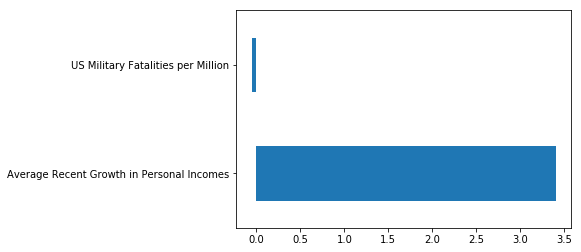

In [0]:
pd.Series(model_lr.coef_.reshape(len(X.columns)), X.columns).plot.barh();

## Dimensionality in Linear Regression

Muliple Regression is simply an extension of the bivariate case. The reason why we see the bivariate case demonstrated so often is simply because it's easier to graph and all of the intuition from the bivariate case is the same as we keep on adding explanatory variables.

As we increase the number of $x$ values in our model we are simply fitting a n-1-dimensional plane to an n-dimensional cloud of points within an n-dimensional hypercube. 

## Interpreting Coefficients

One of Linear Regression's strengths is that the parameters of the model (coefficients) are readily interpretable and useful. Not only do they describe the relationship between x and y but they put a number on just how much x is associated with y. We should be careful to not speak about this relationshiop in terms of causality because these coefficients are in fact correlative measures. We would need a host of additional techniques in order to estimate a causal effect using linear regression (econometrics).

\begin{align}
\hat{\beta} = \frac{Cov(x,y)}{Var(y)}
\end{align}

## Why is Linear Regression so Important?

### Popularity 

Linear Regression is an extremely popular technique that every data scientist **needs** to understand. It's not the most advanced technique and there are supervised learning techniques that will obtain a higher accuracy, but where it lacks in accuracy it makes up for it in interpretability and simplicity.

### Interpretability

Few other models possess coefficients that are so directly linked to their variables with a such a clear interpretation. Tomorrow we're going to learn about ways to make them even easier to interpret.

### Simplicity

A linear regression model can be communicated just by writing out its equation. It's kind of incredible that such high dimensional relationships can be described from just a linear combination of variables and coefficients. 

# Assignment
- Continue to predict New York City apartment rents. This is your last assignment with this dataset.
- You may select any number of features. You are encouraged to engineer new features.
- Get and plot your model's coefficients.
- Report your Root Mean Squared Error, Mean Absolute Error, and R^2 Score, for your Train and Test sets. Share your scores with your cohort on Slack!
- Fit a model with 2 features, and visualize the plane of best fit in 3D.
- Commit your notebook to your fork of the repo.

## Stretch Goals

Study more about Linear Regression. Here are two helpful links. If you find more links, share your favorites with your cohort on Slack.

1. Watch this 20 minute video that just hit 1 million views: Brandon Foltz, Statistics 101: Simple Linear Regression (https://www.youtube.com/watch?v=ZkjP5RJLQF4)
2. Skim _An Introduction to Statistical Learning_, Chapter 3.1, Simple Linear Regression, & Chapter 3.2, Multiple Linear Regression (http://www-bcf.usc.edu/~gareth/ISL/ISLR%20Seventh%20Printing.pdf)

In your 3D visualization, can you include the actual datapoints, like in [this notebook](https://nbviewer.jupyter.org/urls/s3.amazonaws.com/datarobotblog/notebooks/multiple_regression_in_python.ipynb)? Can you also include the residual lines from the datapoints to the plane of the best fit, like in _An Introduction to Statistical Learning?_ This would be hard to do, but awesome!


Can you get creative with feature engineering? Share with your cohort on Slack. We mentioned some feature ideas at the end of last lesson, but didn't demonstrate how to engineer them. So here are some example solutions:

```python
# Does apartment have a non-empty description?
df['description'] = df['description'].str.strip().fillna('')
df['has_description'] = df['description'] != ''

# How long is the description?
df['description_length'] = df['description'].str.len()

# How many total perks does each apartment have?
perk_cols = ['elevator', 'cats_allowed', 'hardwood_floors', 'dogs_allowed',
             'doorman', 'dishwasher', 'no_fee', 'laundry_in_building',
             'fitness_center', 'pre-war', 'laundry_in_unit', 'roof_deck',
             'outdoor_space', 'dining_room', 'high_speed_internet', 'balcony',
             'swimming_pool', 'new_construction', 'exclusive', 'terrace', 
             'loft', 'garden_patio', 'common_outdoor_space', 
             'wheelchair_access']
df['perk_count'] = df[perk_cols].sum(axis=1)

# Are pets allowed?
df['pets_allowed'] = (df['cats_allowed']==1) | (df['dogs_allowed']==1)
```


In [0]:
# refer to module 2 notebook